In [1]:
import talib
import pandas as pd
import loader
import matplotlib.pyplot as plt


In [2]:
SPY = loader.StockDataLoader(file_path="SPY_daily.csv")
df = SPY.LoadData()
df.set_index("Date", inplace=True)
df.head()

✅ Data loaded successfully.
✅ Data validation successful


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,132.00000,132.15625,127.56250,128.812500,83.239784,8737500
2001-01-03,128.31250,136.00000,127.65625,135.000000,87.238220,19431600
2001-01-04,134.93750,135.46875,133.00000,133.546875,86.299164,9219000
2001-01-05,133.46875,133.62500,129.18750,129.187500,83.482094,12911400
2001-01-08,129.87500,130.18750,127.68750,130.187500,84.128296,6625300


In [3]:
"""
Historical Performance-Related Features
Daily gain % (How much gain from yesterday)
Weekly gain average (every week how much we gain on average)
Weekday average/12 weeks (for every day of the week)
Average closing value over a week 
Variation in the closing value over a week (Bolingin Boiler)
Residual of the volume
Last closing day
Last to last closing day
"""
None

In [4]:
def get_weekly_gain_loss(data, price_column='Close'):
    weekly_data = data[price_column].resample('W-FRI').last()  # 'W-FRI' for Friday as the end of the week
    weekly_gain_loss = weekly_data.pct_change() * 100
    return weekly_gain_loss

def weekday_talib_moving_average(df, column, window=14):
    s_moving_averages = pd.Series(index=df.index, dtype=float)
    e_moving_averages = pd.Series(index=df.index, dtype=float)
    for weekday in range(5):  # Monday to Friday (0=Monday, 4=Friday)
        weekday_data = df[df['day'] == weekday][column]
        s_moving_avg = talib.SMA(weekday_data.values, timeperiod=window)
        s_moving_averages[weekday_data.index] = s_moving_avg
        e_moving_avg = talib.EMA(weekday_data.values, timeperiod=window)
        e_moving_averages[weekday_data.index] = e_moving_avg
    return s_moving_averages, e_moving_averages

In [5]:
# Add weekday information (0=Monday, 6=Sunday)
df["day"] = df.index.weekday
# Simple Moving Ave
df["SMA"] = talib.SMA(df["Close"])
# EMA
df["EMA"] = talib.EMA(df["Close"])
# RSI
df["RSI"] = talib.RSI(df["Close"])
# Bollinger Bands
df["upperband"], df["middleband"], df["lowerband"] = talib.BBANDS(df['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
# Calculate daily gain/loss 
df['daily_gain_loss_%'] = talib.ROC(df['Close'].values, timeperiod=1)
# Calculate weekly gain/loss 
df['weekly_gain_loss_%'] = get_weekly_gain_loss(data=df, price_column='Close').reindex(df.index,method="bfill")
# moving average for each weekday group
df['weekday_s_moving_avg_%'], df['weekday_e_moving_avg_%'] = weekday_talib_moving_average(df,'Close',window=4)
# 6. Residual of the Volume (Residuals using a rolling mean subtraction)
df['Volume_MA'] = df['Volume'].rolling(window=5).mean()  # 5-day moving average for volume
df['Volume_Residual'] = df['Volume'] - df['Volume_MA']
# 7. Last Closing Day (Last closing price from the last trading day)
df['Last_Closing'] = df['Close'].shift(1)

# 8. Last to Last Closing Day (Closing price from two trading days ago)
df['Last_Last_Closing'] = df['Close'].shift(2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5979 entries, 2001-01-02 to 2024-10-08
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Open                    5979 non-null   float64
 1   High                    5979 non-null   float64
 2   Low                     5979 non-null   float64
 3   Close                   5979 non-null   float64
 4   Adj Close               5979 non-null   float64
 5   Volume                  5979 non-null   int64  
 6   day                     5979 non-null   int32  
 7   SMA                     5950 non-null   float64
 8   EMA                     5950 non-null   float64
 9   RSI                     5965 non-null   float64
 10  upperband               5975 non-null   float64
 11  middleband              5975 non-null   float64
 12  lowerband               5975 non-null   float64
 13  daily_gain_loss_%       5978 non-null   float64
 14  weekly_gain_loss_%    

In [7]:
# Filter the data to only include records from 2024-01-01 to today
start_date = '2024-01-01'
df = df.loc[start_date:]

# Reindex the DataFrame to include all calendar days, including weekends
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex to the new date range, filling missing values (weekends) with the last available weekday data
df_filled = df.reindex(all_dates, method='ffill')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194 entries, 2024-01-02 to 2024-10-08
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Open                    194 non-null    float64
 1   High                    194 non-null    float64
 2   Low                     194 non-null    float64
 3   Close                   194 non-null    float64
 4   Adj Close               194 non-null    float64
 5   Volume                  194 non-null    int64  
 6   day                     194 non-null    int32  
 7   SMA                     194 non-null    float64
 8   EMA                     194 non-null    float64
 9   RSI                     194 non-null    float64
 10  upperband               194 non-null    float64
 11  middleband              194 non-null    float64
 12  lowerband               194 non-null    float64
 13  daily_gain_loss_%       194 non-null    float64
 14  weekly_gain_loss_%     

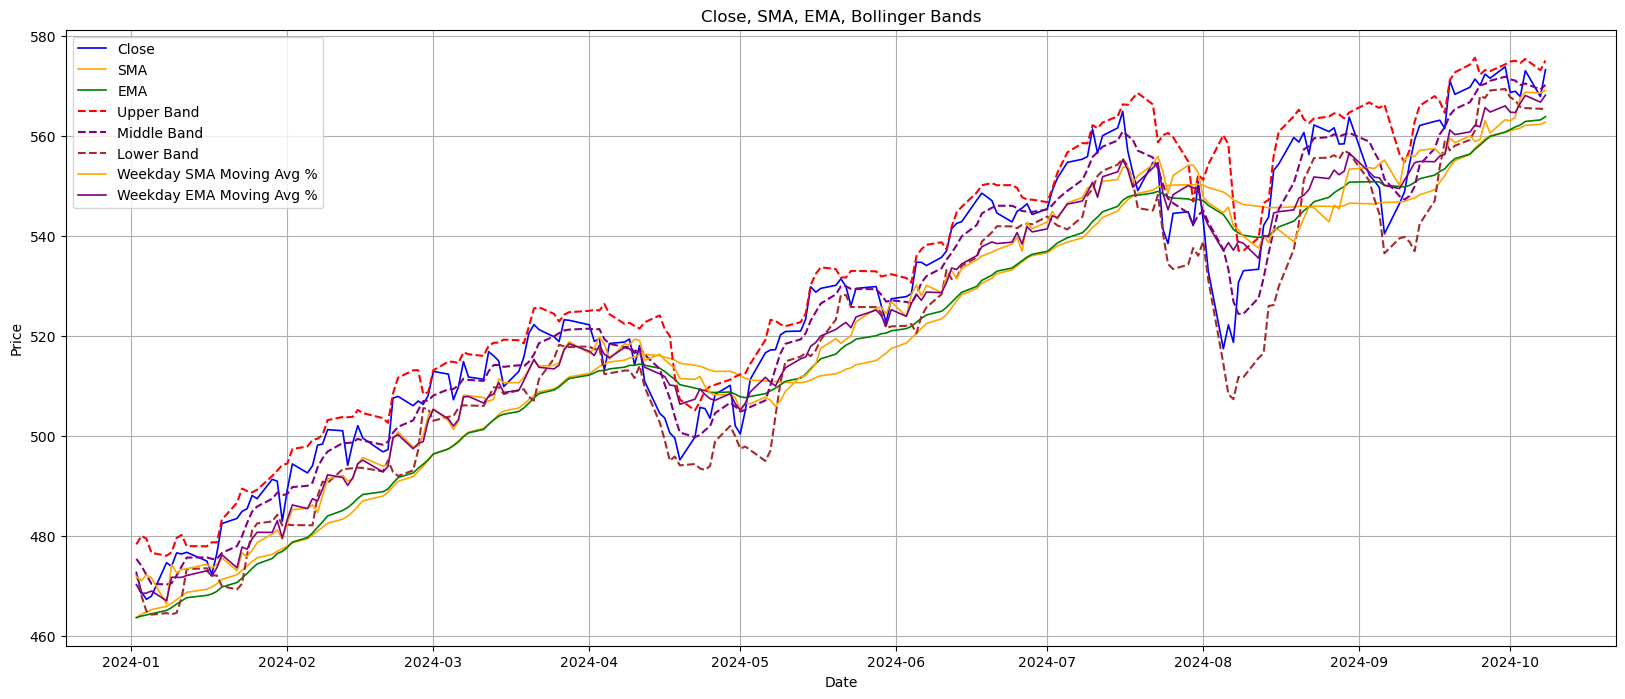

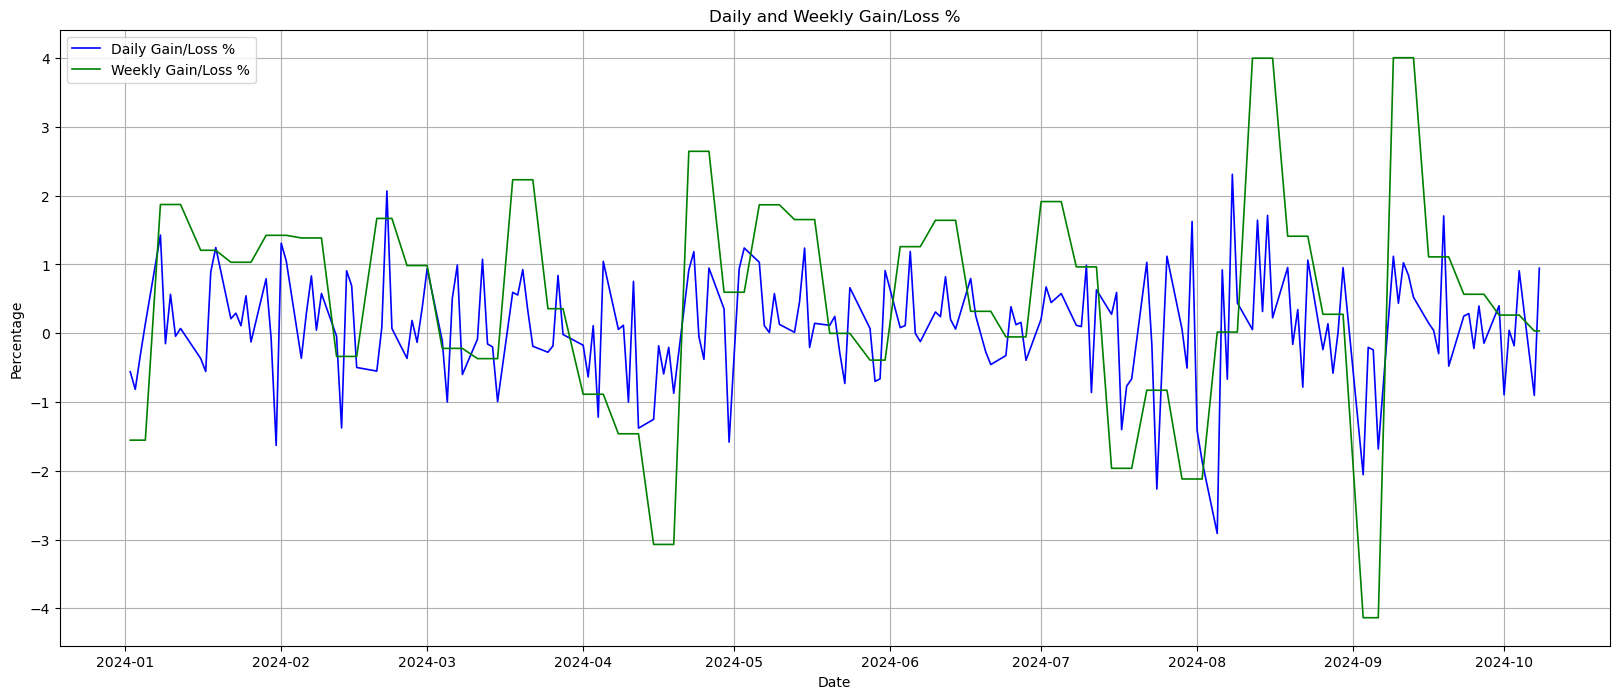

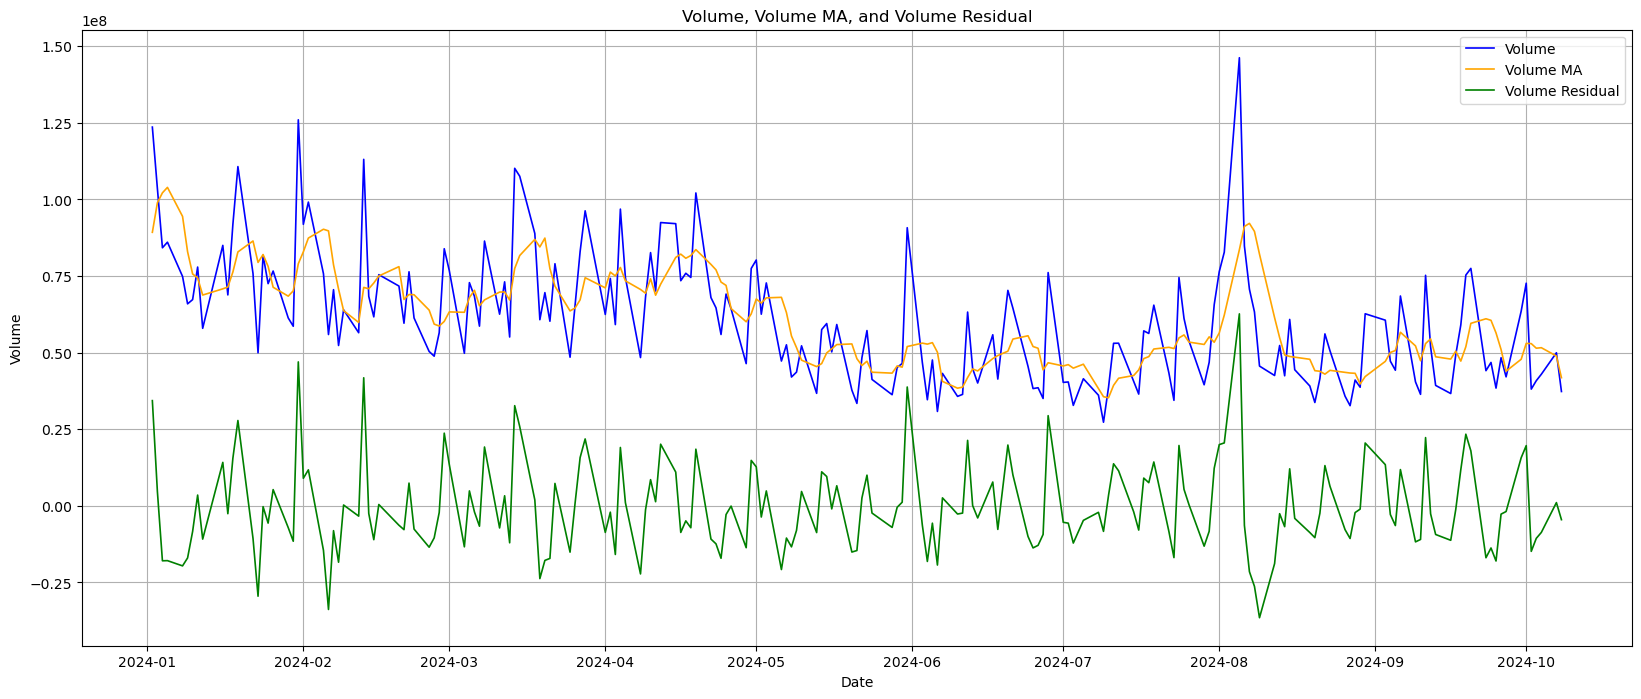

In [9]:

# First graph: Plot Close, SMA, EMA, upperband, middleband, lowerband
size = (20, 8)
plt.figure(figsize=size)
plt.plot(df.index, df['Close'], label='Close', color='blue', linewidth=1.2)
plt.plot(df.index, df['SMA'], label='SMA', color='orange', linewidth=1.2)
plt.plot(df.index, df['EMA'], label='EMA', color='green', linewidth=1.2)
plt.plot(df.index, df['upperband'], label='Upper Band', color='red', linestyle='--')
plt.plot(df.index, df['middleband'], label='Middle Band', color='purple', linestyle='--')
plt.plot(df.index, df['lowerband'], label='Lower Band', color='brown', linestyle='--')
plt.plot(df.index, df['weekday_s_moving_avg_%'], label='Weekday SMA Moving Avg %', color='orange', linewidth=1.2)
plt.plot(df.index, df['weekday_e_moving_avg_%'], label='Weekday EMA Moving Avg %', color='purple', linewidth=1.2)

plt.title('Close, SMA, EMA, Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Second graph: Plot daily_gain_loss_%, weekly_gain_loss_%, weekday_s_moving_avg_%, weekday_e_moving_avg_%
plt.figure(figsize=size)
plt.plot(df.index, df['daily_gain_loss_%'], label='Daily Gain/Loss %', color='blue', linewidth=1.2)
plt.plot(df.index, df['weekly_gain_loss_%'], label='Weekly Gain/Loss %', color='green', linewidth=1.2)

plt.title('Daily and Weekly Gain/Loss %')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()

# Third graph: Plot Volume, Volume_MA, Volume_Residual
plt.figure(figsize=size)
plt.plot(df.index, df['Volume'], label='Volume', color='blue', linewidth=1.2)
plt.plot(df.index, df['Volume_MA'], label='Volume MA', color='orange', linewidth=1.2)
plt.plot(df.index, df['Volume_Residual'], label='Volume Residual', color='green', linewidth=1.2)

plt.title('Volume, Volume MA, and Volume Residual')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
import plotly.graph_objs as go
import plotly.express as px

# First interactive graph: Close, SMA, EMA, upperband, middleband, lowerband as a time series
fig1 = go.Figure()

fig1.add_trace(go.Scatter(x=df_filled.index, y=df_filled['Close'], mode='lines', name='Close', line=dict(color='blue')))
fig1.add_trace(go.Scatter(x=df_filled.index, y=df_filled['SMA'], mode='lines', name='SMA', line=dict(color='orange')))
fig1.add_trace(go.Scatter(x=df_filled.index, y=df_filled['EMA'], mode='lines', name='EMA', line=dict(color='green')))
fig1.add_trace(go.Scatter(x=df_filled.index, y=df_filled['upperband'], mode='lines', name='Upper Band', line=dict(color='red', dash='dash')))
fig1.add_trace(go.Scatter(x=df_filled.index, y=df_filled['middleband'], mode='lines', name='Middle Band', line=dict(color='purple', dash='dash')))
fig1.add_trace(go.Scatter(x=df_filled.index, y=df_filled['lowerband'], mode='lines', name='Lower Band', line=dict(color='brown', dash='dash')))
fig1.add_trace(go.Scatter(x=df_filled.index, y=df_filled['weekday_s_moving_avg_%'], mode='lines', name='Weekday SMA Moving Avg %', line=dict(color='orange')))
fig1.add_trace(go.Scatter(x=df_filled.index, y=df_filled['weekday_e_moving_avg_%'], mode='lines', name='Weekday EMA Moving Avg %', line=dict(color='purple')))

fig1.update_layout(title='Close, SMA, EMA, and Bollinger Bands (with weekends filled)', xaxis_title='Date', yaxis_title='Price', hovermode="x unified")
fig1.show()

# Second interactive graph: daily_gain_loss_%, weekly_gain_loss_%, weekday_s_moving_avg_%, weekday_e_moving_avg_% as a time series
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x=df_filled.index, y=df_filled['daily_gain_loss_%'], mode='lines', name='Daily Gain/Loss %', line=dict(color='blue')))
fig2.add_trace(go.Scatter(x=df_filled.index, y=df_filled['weekly_gain_loss_%'], mode='lines', name='Weekly Gain/Loss %', line=dict(color='green')))

fig2.update_layout(title='Daily and Weekly Gain/Loss % (with weekends filled)', xaxis_title='Date', yaxis_title='Percentage', hovermode="x unified")
fig2.show()

# Third interactive graph: Volume, Volume MA, Volume Residual as a time series
fig3 = go.Figure()

fig3.add_trace(go.Scatter(x=df_filled.index, y=df_filled['Volume'], mode='lines', name='Volume', line=dict(color='blue')))
fig3.add_trace(go.Scatter(x=df_filled.index, y=df_filled['Volume_MA'], mode='lines', name='Volume MA', line=dict(color='orange')))
fig3.add_trace(go.Scatter(x=df_filled.index, y=df_filled['Volume_Residual'], mode='lines', name='Volume Residual', line=dict(color='green')))

fig3.update_layout(title='Volume, Volume MA, and Volume Residual (with weekends filled)', xaxis_title='Date', yaxis_title='Volume', hovermode="x unified")
fig3.show()


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194 entries, 2024-01-02 to 2024-10-08
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Open                    194 non-null    float64
 1   High                    194 non-null    float64
 2   Low                     194 non-null    float64
 3   Close                   194 non-null    float64
 4   Adj Close               194 non-null    float64
 5   Volume                  194 non-null    int64  
 6   day                     194 non-null    int32  
 7   SMA                     194 non-null    float64
 8   EMA                     194 non-null    float64
 9   RSI                     194 non-null    float64
 10  upperband               194 non-null    float64
 11  middleband              194 non-null    float64
 12  lowerband               194 non-null    float64
 13  daily_gain_loss_%       194 non-null    float64
 14  weekly_gain_loss_%     

In [13]:
df = df_filled.copy()  
# Selecting features (excluding Date, Last_Closing and Last_Last_Closing for prediction)
features = ['Open', 'High', 'Low', 'Volume', 'SMA', 'EMA', 'RSI', 
            'upperband', 'middleband', 'lowerband', 'daily_gain_loss_%', 
            'weekly_gain_loss_%', 'Volume_MA', 'Volume_Residual']


features2 = ['Volume', 'daily_gain_loss_%', 
            'weekly_gain_loss_%', 'Volume_MA', 'Volume_Residual']

X = df[features2]  # Features
y = df['Close']   # Target variable (Close price)

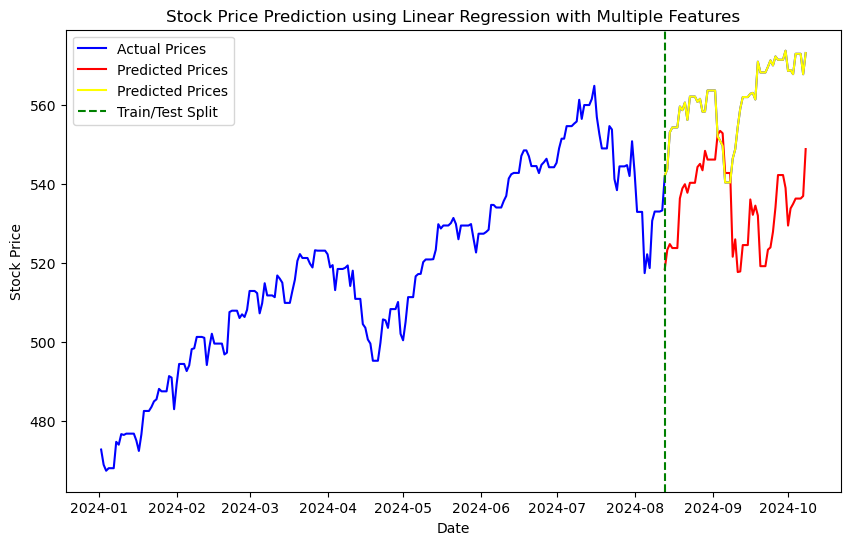

Mean Squared Error: 881.99


In [14]:
# Split the data into 80% training and 20% testing
split_index = int(0.8 * len(df))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot the actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(df.index, y, label='Actual Prices', color='blue')
plt.plot(df.index[split_index:], y_pred, label='Predicted Prices', color='red')
plt.plot(df.index[split_index:],y_test,label='Predicted Prices', color='yellow')
plt.axvline(df.index[split_index], color='green', linestyle='--', label='Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Stock Price Prediction using Linear Regression with Multiple Features')
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

In [15]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared (R² Score)
r2 = r2_score(y_test, y_pred)

# Print all evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R² Score): {r2:.2f}")



Mean Squared Error (MSE): 881.99
Mean Absolute Error (MAE): 26.87
R-squared (R² Score): -9.32
